<a href="https://colab.research.google.com/github/siruku6/fx_notebooks/blob/master/220911_ml_strict_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. モジュールの準備

In [1]:
!pip install -q pytorch_lightning torchinfo

     |████████████████████████████████| 706 kB 5.3 MB/s 
     |████████████████████████████████| 419 kB 66.8 MB/s 
     |████████████████████████████████| 5.9 MB 46.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [23]:
import os
from glob import glob
from typing import List

from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tqdm.notebook import tqdm

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataset import Subset
import torchmetrics
from torchmetrics.functional import accuracy, f1_score
from torchmetrics import F1Score
import torchvision
from torchinfo import summary


# 2. データの準備


## 2-1. ~~アップロード~~ Google Driveのデータを展開

In [ ]:
# # Upload `chart_pngs.zip`
# uploaded = files.upload()
# !unzip chart_pngs.zip

!unzip "drive/MyDrive/Colab Notebooks/data/fx_chart_image_trial/chart_pngs.zip"


In [13]:
# # Upload `fx_train_test_data.cav` or `fx_strict_train_test_data.csv`
# uploaded = files.upload()

chart_csv_path: str = "drive/MyDrive/Colab Notebooks/data/fx_chart_image_trial/train_test_data.csv"

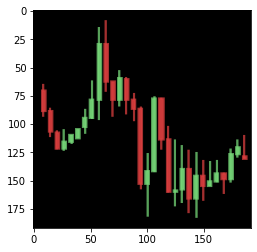

In [10]:
sample_image: str = './content/chart_pngs/sample_2511.png'
with open(sample_image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('RGB')

plt.imshow(image)
plt.show()

In [9]:
filenames: List[str] = glob('./content/chart_pngs/*')
len(filenames)

3833

In [22]:
# data_source_file_name: str = 'fx_train_test_data.csv'
data_source_file_name: str = chart_csv_path

df = pd.read_csv(f'{data_source_file_name}')
print("Size of df", len(df))
df.head(5)


Size of df 3863


,low,open,high,close,time,close:lag+1,close:lag+2,close:lag+3,close:lag+4,close:lag+5,class,max_between_lag+1_log+4,min_between_lag+1_log+4
0,156.053,156.087,156.193,156.136,2021-10-31 21:00:00,156.226,156.311,155.992,156.185,156.134,0,156.311,155.992
1,156.088,156.117,156.240,156.226,2021-10-31 22:00:00,156.311,155.992,156.185,156.134,156.225,0,156.311,155.992
2,156.118,156.224,156.334,156.311,2021-10-31 23:00:00,155.992,156.185,156.134,156.225,156.238,0,156.225,155.992
3,155.922,156.314,156.338,155.992,2021-11-01 00:00:00,156.185,156.134,156.225,156.238,156.351,0,156.238,156.134
4,155.952,155.990,156.204,156.185,2021-11-01 01:00:00,156.134,156.225,156.238,156.351,156.274,0,156.351,156.134


## 2-2. Identify the degree of data imbalance

In [42]:
y = df["class"] # classes

df.groupby("class")["class"].count()


class
0    3686
1      62
2     115
Name: class, dtype: int64

In [48]:
# calc class_weight for passing to loss function
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(class_weights)

tensor([ 0.3493, 20.7688, 11.1971])


## 2-3. Preprocess

In [15]:
# 末尾30行を削除
print("Size of images:", len(filenames))
print("Size of df: ", len(df))

Size of images: 3833
Size of df:  3863


1枚の画像を作るのに30行必要なので、画像の方が、データ30行分少ない

そのため、後で学習データを作成する時は、csvの末尾30行を無視してデータを作成する

In [16]:
# こんな感じでOK
df[['class']][:-30].to_numpy()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
print("Size of df: ", len(df[['class']][:-30]))

Size of df:  3833


## 2-4. DataLoaderの作成

In [17]:
os.listdir('./content/chart_pngs')[:4]

['sample_665.png', 'sample_3479.png', 'sample_929.png', 'sample_2780.png']

In [18]:
filenames = sorted(os.listdir('./content/chart_pngs'))
filenames[:4]

['sample_0.png', 'sample_1.png', 'sample_10.png', 'sample_100.png']

In [19]:
# 元の並び順も、sorted実行後も画像の順番が時系列順にならないので、自分でファイル名配列を作る
filenames = [f'sample_{index}.png' for index in range(0, 3634)]
filenames[:10]

['sample_0.png',
 'sample_1.png',
 'sample_2.png',
 'sample_3.png',
 'sample_4.png',
 'sample_5.png',
 'sample_6.png',
 'sample_7.png',
 'sample_8.png',
 'sample_9.png']

In [20]:
# Dataset作成
class ChartDataset(torch.utils.data.Dataset):
    def __init__(self, data_source: str, transform=None):
        self.transform = transform
        self.images: List[str] = [f'sample_{index}.png' for index in range(0, 3634)]

        # 末尾30行を無視
        df_chart: pd.DataFrame = pd.read_csv(f'./{data_source}')[:-30]
        self.labels = df_chart['class'].to_numpy()

    def __getitem__(self, index: int):
        image: str = self.images[index]
        label: np.ndarray = self.labels[index]

        with open(f'./content/chart_pngs/{image}', 'rb') as f:
            image = Image.open(f).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)


In [21]:
# seed 固定
pl.seed_everything(0)

# Dataset初期化
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
chart_dataset: ChartDataset = ChartDataset(data_source_file_name, transform=transforms)

n_train: int = int(len(chart_dataset) * 0.6)
n_val: int = int(len(chart_dataset) * 0.2)
n_test: int = len(chart_dataset) - n_train - n_val

train_indices: List[int] = list(range(0, n_train))
val_indices: List[int] = list(range(n_train, n_train + n_val))
test_indices: List[int] = list(range(n_train + n_val, len(chart_dataset)))

# NOTE: Subset をつかうと randomではない分割が可能
# https://qiita.com/takurooo/items/ba8c509eaab080e2752c#%E8%A7%A3%E6%B1%BA%E7%AD%961-torchutilsdatasubset
# FXは過去のデータから未来の予測をしたいので、学習データは過去データ。
# validation, testデータは未来のデータ、という分け方にしたい。
train = Subset(chart_dataset, train_indices)
val = Subset(chart_dataset, val_indices)
test = Subset(chart_dataset, test_indices)

# DataLoader作成
batch_size = 50
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0]


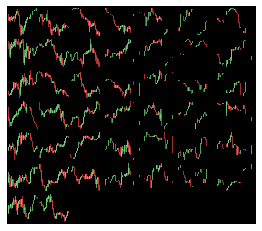

In [35]:
# DataLoaderの動作確認
def show_sample_images(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2 ,0)), interpolation='nearest')

for _, (images, labels) in enumerate(train_loader):
    print(labels.numpy())
    show_sample_images(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    break


# 3. Trial1

シンプルに学習

## 3-1. 学習ネットワーク実装

In [36]:
# 画像入力サイズの確認
image, label = next(iter(train_loader))
image.shape

torch.Size([50, 3, 192, 192])

In [37]:
# 1 layerずつ動作確認
conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
dropout1 = nn.Dropout2d(p=0.25)
conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
dropout2 = nn.Dropout2d(p=0.25)

fc1 = nn.Linear(13824, 256)
dropout3 = nn.Dropout(p=0.5)
fc2 = nn.Linear(256, 3)


image, label = next(iter(train_loader))

h = conv1(image)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)

h = conv2(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)
h = dropout1(h)

h = conv3(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)

h = conv4(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)
h = dropout2(h)
# h.shape -> torch.Size([30, 96, 12, 12])
# 96 * 12 * 12 -> 13824

h = h.view(-1, 13824)  # ベクトル化

h = fc1(h)
h = F.relu(h)
h = dropout3(h)
y = fc2(h)
y.shape

# 動いた

torch.Size([50, 3])

In [38]:
label

tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [39]:
# F.cross_entropy(y, label)
F.cross_entropy(y, label, weight=class_weights)

tensor(1.0751, grad_fn=<NllLossBackward0>)

In [40]:
class Network(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

        self.f1 = F1Score(num_classes=3)

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)
        h = self.fc2(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.f1(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.SGD(params=self.parameters(), lr=0.001)
        # return optimizer
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer, ], [scheduler, ]

In [ ]:
# アーキテクチャの確認
net = Network()  # .cuda()
summary(net, input_size=(3, 192, 192))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 3]                    --
├─Conv2d: 1-1                            [32, 192, 192]            896
├─Conv2d: 1-2                            [48, 96, 96]              13,872
├─Dropout2d: 1-3                         [48, 48, 48]              --
├─Conv2d: 1-4                            [64, 48, 48]              27,712
├─Conv2d: 1-5                            [96, 24, 24]              55,392
├─Dropout2d: 1-6                         [96, 12, 12]              --
├─Linear: 1-7                            [1, 256]                  3,539,200
├─Dropout: 1-8                           [1, 256]                  --
├─Linear: 1-9                            [1, 3]                    771
Total params: 3,637,843
Trainable params: 3,637,843
Non-trainable params: 0
Total mult-adds (M): 285.72
Input size (MB): 0.44
Forward/backward pass size (MB): 14.60
Params size (MB): 14.55
Estimated Total

結構ネットワーク大きい

画像サイズ減らしても精度落ちないのであれば減らしたい

## 3-2. training / validation

In [ ]:
# gpu有効なら実行しておく
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

if torch.cuda.is_available():
    import psutil
    import humanize
    import os
    import GPUtil as GPU

    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=09d7ad53d0ac524efd5d3833a431a1c89df3bdb9ae6750101b2ee08a13367884
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.0 GB  |     Proc size: 1.2 GB
GPU RAM Free: 15106MB | Used: 3MB | Util   0% | Total     15109MB


In [ ]:
# 学習
pl.seed_everything(0)
net = Network()

log_dir: str = 'fx_trader'
logger = CSVLogger(save_dir='logs', name=log_dir)
trainer = pl.Trainer(max_epochs=30, gpus=1, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)
trainer.callback_metrics

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 13.9 K
2 | dropout1 | Dropout2d | 0     
3 | conv3    | Conv2d    | 27.7 K
4 | conv4    | Conv2d    | 55.4 K
5 | dropout2 | Dropout2d | 0     
6 | fc1      | Linear    | 3.5 M 
7 | dropout3 | Dropout   | 0     
8 | fc2      | Linear    | 771   
---------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.551    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'train_f1': tensor(0.9888),
 'train_f1_epoch': tensor(0.9888),
 'train_f1_step': tensor(0.9800),
 'train_loss': tensor(0.0267),
 'train_loss_epoch': tensor(0.0267),
 'train_loss_step': tensor(0.0393),
 'val_f1': tensor(0.9587),
 'val_loss': tensor(0.2866)}

## 3-3. test

In [ ]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/fx_trader/version_1/checkpoints/epoch=29-step=1290.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/fx_trader/version_1/checkpoints/epoch=29-step=1290.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9052197933197021
        test_loss           0.5223508477210999
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_f1': 0.9052197933197021, 'test_loss': 0.5223508477210999}]

## 3-4. Display result

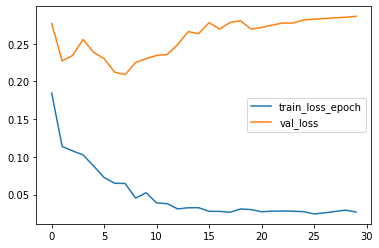

In [ ]:
# 結果確認
log = pd.read_csv(f'logs/{log_dir}/version_1/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

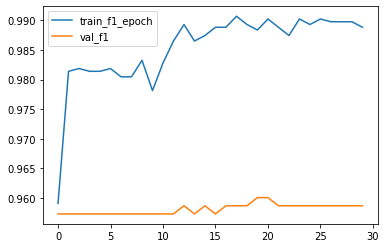

In [ ]:
log[['train_f1_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_f1_epoch'].plot()
log[['val_f1', 'epoch']].dropna(how='any', axis=0).reset_index()['val_f1'].plot()
plt.legend()


In [ ]:
model_file_name: str = '220627_fx_model.pt'
torch.save(net.state_dict(), model_file_name)

class InferenceNet(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)
        h = self.fc2(h)
        return h

inf_net = InferenceNet().cpu().eval()
inf_net.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

preds_list = []
target_list = []
with torch.no_grad():
    # dataの取り出し
    for x, t in tqdm(test_loader):
        image = x.float()
        # image = x.to(DEVICE)

        preds = inf_net(image)
        preds = preds.to('cpu')
        
        preds_list = preds_list + preds.argmax(dim=1).tolist()
        target_list = target_list + t.numpy().reshape(-1).tolist()


  0%|          | 0/15 [00:00<?, ?it/s]

[[653   0   1]
 [ 27   0   0]
 [ 41   0   6]]


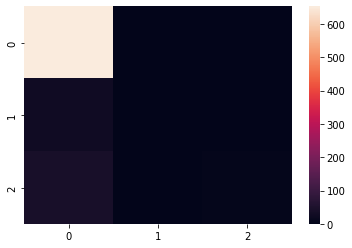

In [ ]:
cm = confusion_matrix(target_list, preds_list)
print(cm)
sns.heatmap(cm)

ほとんどまともに分類できていない

ほぼ全て 0 として予測されている

# 4. Trial2

損失関数（loss）を変更した ネットワークでFine tuning

## 4-1. カスタムLoss定義

### 4-1-1. IBLoss

https://github.com/pseulki/IB-Loss/blob/main/losses.py#L18-L35

https://qiita.com/koshian2/items/52e4bdc682fc152fe05e

In [55]:
def ib_loss(input_values, ib):
    """Computes the focal loss"""
    loss = input_values * ib
    return loss.mean()

class IBLoss(nn.Module):
    def __init__(self, weight=None, alpha=10000.):
        super(IBLoss, self).__init__()
        assert alpha > 0
        self.alpha = alpha
        self.epsilon = 0.001
        self.weight = weight
        self.num_classes: int = len(weight)

    def forward(self, input, target, features):
        grads = torch.sum(torch.abs(F.softmax(input, dim=1) - F.one_hot(target, self.num_classes)), 1) # N * 1
        ib = grads * features.reshape(-1)
        ib = self.alpha / (ib + self.epsilon)
        return ib_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), ib)

In [57]:
# class
# 0    3656
# 1      62
# 2     115

cls_num_list = [3656, 62, 115]
per_cls_weights = 1.0 / np.array(cls_num_list)
per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
per_cls_weights = torch.FloatTensor(per_cls_weights) # .cuda()
per_cls_weights


tensor([0.0327, 1.9279, 1.0394])

In [58]:
criterion_ib = IBLoss(weight=per_cls_weights, alpha=1000)


### 4-1-2. Focal Loss

https://take-tech-engineer.com/pytorch-focal-loss/#toc1

In [ ]:
class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
        super(Focal_MultiLabel_Loss, self).__init__()
        self.gamma = gamma
        self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets, _): 
        bce = self.bceloss(outputs, targets)
        bce_exp = torch.exp(-bce)
        focal_loss = (1-bce_exp)**self.gamma * bce
        return focal_loss.mean()

In [ ]:
# https://ni4muraano.hatenablog.com/entry/2020/01/12/144549
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target, _):
        target = target.float()

        # BCELossWithLogits
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
               ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size()) == 2:
            loss = loss.sum(dim=1)
        return loss.mean()

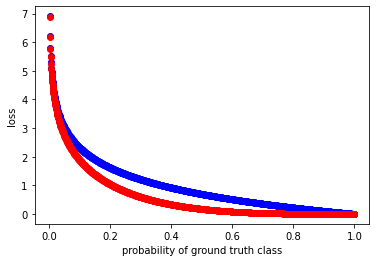

In [ ]:
# binary cross entropy
loss = nn.BCELoss(reduction='none')
target = torch.Tensor([1])
for input in torch.arange(0.001, 1, 0.001):
    output = loss(input, target[0])
    plt.scatter(input, output, color = "blue")

# focal loss γ=2
loss = Focal_MultiLabel_Loss(gamma=2)
for input in torch.arange(0.001, 1, 0.001):
    output = loss(input, target[0])
    plt.scatter(input, output, color = "red")

plt.xlabel('probability of ground truth class')
plt.ylabel('loss');

In [ ]:
criterion_fl = Focal_MultiLabel_Loss(gamma=4)
criterion_fl2 = FocalLoss(gamma=4)

## 4-2. Network再構築

In [ ]:
class NetworkWithIBLoss(pl.LightningModule):

    def __init__(self, criterion = None):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

        self.criterion = criterion
        self.f1 = F1Score(num_classes=3)

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)

        feats = torch.flatten(h, 1)
        h = self.fc2(h)
        return h, torch.sum(torch.abs(feats), 1).reshape(-1, 1)

    def training_step(self, batch, batch_idx):
        x, t = batch
        y, features = self(x)

        if self.criterion is not None:
            loss = self.criterion(y, t, features)
        else:
            loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.f1(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y, features = self(x)

        if self.criterion is not None:
            loss = self.criterion(y, t, features)
        else:
            loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y, features = self(x)

        if self.criterion is not None:
            loss = self.criterion(y, t, features)
        else:
            loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.SGD(params=self.parameters(), lr=0.001)
        # return optimizer
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer, ], [scheduler, ]

## 4-3. ネットワークの動作確認

In [ ]:
# 1 layerずつ動作確認
# ---------------------------------------------------------------
conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
dropout1 = nn.Dropout2d(p=0.25)
conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
dropout2 = nn.Dropout2d(p=0.25)

fc1 = nn.Linear(13824, 256)
dropout3 = nn.Dropout(p=0.5)
fc2 = nn.Linear(256, 3)
# ---------------------------------------------------------------


image, label = next(iter(train_loader))

h = conv1(image)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)

h = conv2(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)
h = dropout1(h)

h = conv3(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)

h = conv4(h)
h = F.relu(h)
h = F.max_pool2d(h, kernel_size=2, stride=2)
h = dropout2(h)
# h.shape -> torch.Size([30, 96, 12, 12])
# 96 * 12 * 12 -> 13824

h = h.view(-1, 13824)  # ベクトル化

h = fc1(h)
h = F.relu(h)
h = dropout3(h)
feats = torch.flatten(h, 1)

y = fc2(h)

features = torch.sum(torch.abs(feats), 1).reshape(-1, 1)
y.shape, features.shape

# 動いた

(torch.Size([50, 3]), torch.Size([50, 1]))

In [ ]:
y.shape, label.shape

(torch.Size([50, 3]), torch.Size([50]))

In [ ]:
criterion_ib(y, label, features)

tensor(26.9126, grad_fn=<MeanBackward0>)

In [ ]:
target_array = np.zeros(y.shape)

for index, l in enumerate(label.numpy()):
    target_array[index][l] = 1

print(target_array.shape)
torch.LongTensor(target_array).shape

In [ ]:
criterion_fl(y, target_array, features)


In [ ]:
criterion_fl2(y, label, features)


## 4-4. IBLossを使ったネットワークで再学習/検証/テスト

In [ ]:
# 学習
pl.seed_everything(0)
net = Network()

log_dir: str = 'fx_trader'
logger = CSVLogger(save_dir='logs', name=log_dir)
trainer = pl.Trainer(max_epochs=20, gpus=1, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)

model_file_name: str = '220627_fx_model_with_ibloss.pt'
torch.save(net.state_dict(), model_file_name)

# ------------------------------------------
# fine tuning

net_ib = NetworkWithIBLoss(criterion=criterion_ib)
net_ib.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

log_dir: str = 'fx_trader'
trainer = pl.Trainer(max_epochs=20, gpus=1, deterministic=True, logger=logger)
trainer.fit(net_ib, train_loader, val_loader)

trainer.callback_metrics

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 13.9 K
2 | dropout1 | Dropout2d | 0     
3 | conv3    | Conv2d    | 27.7 K
4 | conv4    | Conv2d    | 55.4 K
5 | dropout2 | Dropout2d | 0     
6 | fc1      | Linear    | 3.5 M 
7 | dropout3 | Dropout   | 0     
8 | fc2      | Linear    | 771   
---------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.551    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | conv1     | Conv2d    | 896   
1 | conv2     | Conv2d    | 13.9 K
2 | dropout1  | Dropout2d | 0     
3 | conv3     | Conv2d    | 27.7 K
4 | conv4     | Conv2d    | 55.4 K
5 | dropout2  | Dropout2d | 0     
6 | fc1       | Linear    | 3.5 M 
7 | dropout3  | Dropout   | 0     
8 | fc2       | Linear    | 771   
9 | criterion | IBLoss    | 0     
----------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.551    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

{'train_f1': tensor(0.6516),
 'train_f1_epoch': tensor(0.6516),
 'train_f1_step': tensor(0.6400),
 'train_loss': tensor(0.0349),
 'train_loss_epoch': tensor(0.0349),
 'train_loss_step': tensor(0.0643),
 'val_f1': tensor(0.9518),
 'val_loss': tensor(0.0846)}

In [ ]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/fx_trader/version_7/checkpoints/epoch=19-step=860.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/fx_trader/version_7/checkpoints/epoch=19-step=860.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9093406796455383
        test_loss           0.13497531414031982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_f1': 0.9093406796455383, 'test_loss': 0.13497531414031982}]

## 4-5. 学習経過の可視化

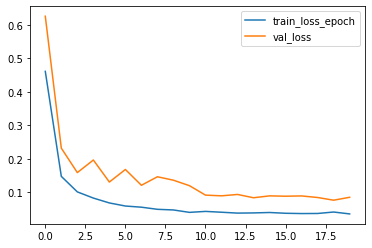

In [ ]:
# 結果確認
log = pd.read_csv(f'logs/{log_dir}/version_7/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

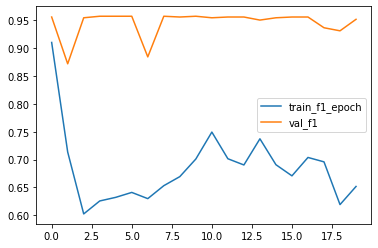

In [ ]:
log[['train_f1_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_f1_epoch'].plot()
log[['val_f1', 'epoch']].dropna(how='any', axis=0).reset_index()['val_f1'].plot()
plt.legend()

  0%|          | 0/15 [00:00<?, ?it/s]

[[654   0   0]
 [ 27   0   0]
 [ 47   0   0]]


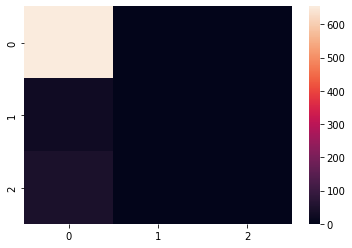

In [ ]:
model_file_name: str = '220627_fx_model_with_ibloss.pt'
torch.save(net.state_dict(), model_file_name)

class InferenceNet(pl.LightningModule):

    def __init__(self, criterion = None):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

        self.criterion = criterion

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)

        feats = torch.flatten(h, 1)
        h = self.fc2(h)
        return h # , torch.sum(torch.abs(feats), 1).reshape(-1, 1)

inf_net = InferenceNet().cpu().eval()
inf_net.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

preds_list = []
target_list = []
with torch.no_grad():
    # dataの取り出し
    for x, t in tqdm(test_loader):
        image = x.float()
        # image = x.to(DEVICE)

        preds = inf_net(image)
        preds = preds.to('cpu')
        
        preds_list = preds_list + preds.argmax(dim=1).tolist()
        target_list = target_list + t.numpy().reshape(-1).tolist()

cm = confusion_matrix(target_list, preds_list)
print(cm)
sns.heatmap(cm)

# 5. Trial3

use argument "weight" of cross_entropy to improve the result of training


## 5-1. Preparation

In [44]:
y = df["class"] # classes

class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(class_weights)

tensor([ 0.3493, 20.7688, 11.1971])


In [45]:
class Network(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

        self.f1 = F1Score(num_classes=3)

    def forward(self, x):
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)
        h = self.fc2(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t, weight=class_weights)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.f1(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t, weight=class_weights)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t, weight=class_weights)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer, ], [scheduler, ]

## 5-2. Training

In [47]:
# 学習
pl.seed_everything(0)
net = Network()

log_dir: str = 'fx_trader'
logger = CSVLogger(save_dir='logs', name=log_dir)
trainer = pl.Trainer(max_epochs=20, gpus=0, deterministic=True, logger=logger)
trainer.fit(net, train_loader, val_loader)

model_file_name: str = '220911_fx_model_using_weight.pt'
torch.save(net.state_dict(), model_file_name)

trainer.callback_metrics

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 896   
1 | conv2    | Conv2d    | 13.9 K
2 | dropout1 | Dropout2d | 0     
3 | conv3    | Conv2d    | 27.7 K
4 | conv4   

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


{'train_loss': tensor(0.1145),
 'train_loss_step': tensor(0.1400),
 'train_f1': tensor(0.9684),
 'train_f1_step': tensor(0.9200),
 'val_loss': tensor(1.2895),
 'val_f1': tensor(0.9559),
 'train_loss_epoch': tensor(0.1145),
 'train_f1_epoch': tensor(0.9684)}

## 5-3. looking into the result

In [49]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/fx_trader/version_0/checkpoints/epoch=19-step=860.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at logs/fx_trader/version_0/checkpoints/epoch=19-step=860.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9093406796455383
        test_loss            2.17714524269104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.17714524269104, 'test_f1': 0.9093406796455383}]

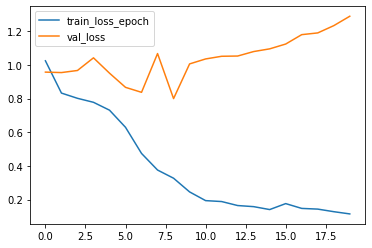

In [51]:
# 結果確認
log = pd.read_csv(f'logs/{log_dir}/version_0/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

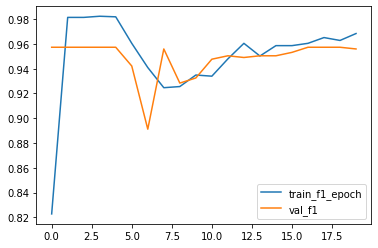

In [52]:
log[['train_f1_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_f1_epoch'].plot()
log[['val_f1', 'epoch']].dropna(how='any', axis=0).reset_index()['val_f1'].plot()
plt.legend()


  0%|          | 0/15 [00:00<?, ?it/s]

[[644   1   9]
 [ 27   0   0]
 [ 29   0  18]]


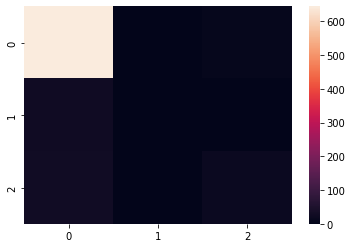

In [53]:
class InferenceNet(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)
        h = self.fc2(h)
        return h

inf_net = InferenceNet().cpu().eval()
inf_net.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

preds_list = []
target_list = []
with torch.no_grad():
    # dataの取り出し
    for x, t in tqdm(test_loader):
        image = x.float()
        # image = x.to(DEVICE)

        preds = inf_net(image)
        preds = preds.to('cpu')
        
        preds_list = preds_list + preds.argmax(dim=1).tolist()
        target_list = target_list + t.numpy().reshape(-1).tolist()

cm = confusion_matrix(target_list, preds_list)
print(cm)
sns.heatmap(cm)

結構改善した

f1 scoreは置いておいて、 class2 のprecisionとrecallが大幅に改善しているのがわかる。  
と言っても、 6/47 => 18/47 という改善だが...

今度はさらに、IBLossを使って改善するかどうかも見てみる

In [54]:
class NetworkWithIBLoss(pl.LightningModule):

    def __init__(self, criterion = None):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.fc1 = nn.Linear(13824, 256)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 3)

        self.criterion = criterion
        self.f1 = F1Score(num_classes=3)

    def forward(self, x):
        # NOTE: 株価予測の論文に大体倣う実装にした
        # https://github.com/rosdyana/Going-Deeper-with-Convolutional-Neural-Network-for-Stock-Market-Prediction/blob/master/myDeepCNN.py
        h = self.conv1(x)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout1(h)

        h = self.conv3(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = self.conv4(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=2, stride=2)
        h = self.dropout2(h)

        h = h.view(-1, 13824)  # テンソルからベクトルへ変換

        h = self.fc1(h)
        h = F.relu(h)
        h = self.dropout3(h)

        feats = torch.flatten(h, 1)
        h = self.fc2(h)
        return h, torch.sum(torch.abs(feats), 1).reshape(-1, 1)

    def training_step(self, batch, batch_idx):
        x, t = batch
        y, features = self(x)

        if self.criterion is not None:
            loss = self.criterion(y, t, features)
        else:
            loss = F.cross_entropy(y, t, weight=class_weights)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.f1(y.softmax(dim=-1), t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y, features = self(x)

        if self.criterion is not None:
            loss = self.criterion(y, t, features)
        else:
            loss = F.cross_entropy(y, t, weight=class_weights)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y, features = self(x)

        if self.criterion is not None:
            loss = self.criterion(y, t, features)
        else:
            loss = F.cross_entropy(y, t, weight=class_weights)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_f1', self.f1(y.softmax(dim=-1), t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # optimizer = torch.optim.SGD(params=self.parameters(), lr=0.001)
        # return optimizer
        optimizer = torch.optim.SGD(params=self.parameters(), lr=0.01, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer, ], [scheduler, ]

In [60]:
# ------------------------------------------
# fine tuning

net_ib = NetworkWithIBLoss(criterion=criterion_ib)
net_ib.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

log_dir: str = 'fx_trader'
trainer = pl.Trainer(max_epochs=20, gpus=0, deterministic=True, logger=logger)
trainer.fit(net_ib, train_loader, val_loader)

trainer.callback_metrics

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/fx_trader/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      |

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


{'train_loss': tensor(0.0144),
 'train_loss_step': tensor(0.0147),
 'train_f1': tensor(0.9540),
 'train_f1_step': tensor(0.9800),
 'val_loss': tensor(0.5424),
 'val_f1': tensor(0.9532),
 'train_loss_epoch': tensor(0.0144),
 'train_f1_epoch': tensor(0.9540)}

In [61]:
results = trainer.test(dataloaders=test_loader)
results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/fx_trader/version_0/checkpoints/epoch=19-step=860-v1.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at logs/fx_trader/version_0/checkpoints/epoch=19-step=860-v1.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9038461446762085
        test_loss           0.6575764417648315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6575764417648315, 'test_f1': 0.9038461446762085}]

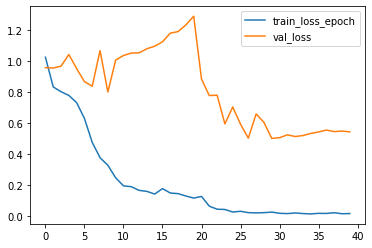

In [64]:
# 結果確認
log = pd.read_csv(f'logs/{log_dir}/version_0/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

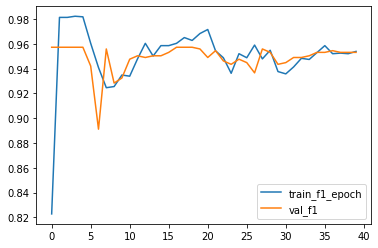

In [65]:
log[['train_f1_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_f1_epoch'].plot()
log[['val_f1', 'epoch']].dropna(how='any', axis=0).reset_index()['val_f1'].plot()
plt.legend()


  0%|          | 0/15 [00:00<?, ?it/s]

[[638   3  13]
 [ 27   0   0]
 [ 27   0  20]]


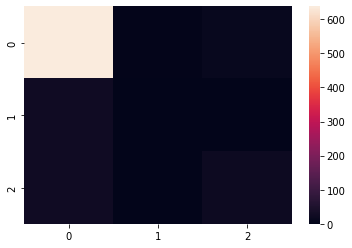

In [68]:
model_file_name: str = '220911_fx_model_using_weight_with_ibloss.pt'
torch.save(net_ib.state_dict(), model_file_name)


inf_net = InferenceNet().cpu().eval()
inf_net.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

preds_list = []
target_list = []
with torch.no_grad():
    # dataの取り出し
    for x, t in tqdm(test_loader):
        image = x.float()
        # image = x.to(DEVICE)

        preds = inf_net(image)
        preds = preds.to('cpu')
        
        preds_list = preds_list + preds.argmax(dim=1).tolist()
        target_list = target_list + t.numpy().reshape(-1).tolist()

cm = confusion_matrix(target_list, preds_list)
print(cm)
sns.heatmap(cm)

# N. その他 / 考察

In [70]:
df_chart = pd.read_csv(chart_csv_path)[:-30]
df_chart.groupby(['class'])['class'].count()

class
0    3656
1      62
2     115
Name: class, dtype: int64

- classごとのデータ数はそこまで大幅に偏っているわけではない
- 今回は足5本先の時点で20pips変動があるかどうかを判定したが、もう少し厳しい条件にした場合などで、精度がどう変わるか見てみてもよいかもしれない
- たとえば、一時的なドローダウンが間に挟まっている場合はトレードしない方が良いので、class: 0（変動なし）扱いにした場合、精度がどう変わるかは気になる

- 無印

    ```python
    [[653   0   1]
    [ 27   0   0]
    [ 41   0   6]]
    ```

- cross_entropy関数にweight引数を渡した場合

    ```python
    [[644   1   9]
    [ 27   0   0]
    [ 29   0  18]]
    ```

- その後 IBLoss を使用してFine Tuningした場合

    ```python
    [[638   3  13]
    [ 27   0   0]
    [ 27   0  20]]
    ```

class 2 に限って言えば 6/47 から 20/47 へと大きな改善が見られた。

ただし、IBLossによる改善は微々たるものなので、IBLossによるFine Tuningなしでもいいかも
